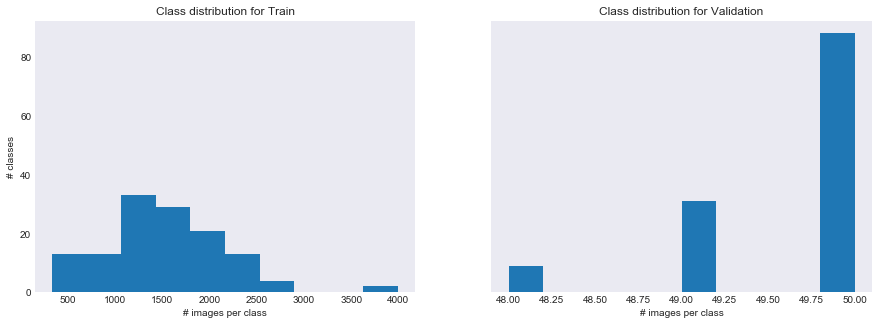

In [20]:
#Калибровка для задачи классификации
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

train_json = json.load(open('C:/Users/Dridgers/Desktop/work/datasets/t271221/train.json'))
train_df = pd.DataFrame(train_json['annotations'])

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax0.hist(train_df.label_id.value_counts())
ax0.set_xlabel("# images per class")
ax0.set_ylabel("# classes")
ax0.set_title('Class distribution for Train')

val_pred = np.loadtxt('C:/Users/Dridgers/Desktop/work/datasets/t271221/furniture_val_true.csv')
ax1.hist(pd.Series(val_pred).value_counts())
ax1.set_xlabel("# images per class")
ax1.set_title('Class distribution for Validation')
f;
plt.show()

In [21]:
def calibrate(prior_y0_train, prior_y0_test,
              prior_y1_train, prior_y1_test,
              predicted_prob_y0):
    predicted_prob_y1 = (1 - predicted_prob_y0)
    
    p_y0 = prior_y0_test * (predicted_prob_y0 / prior_y0_train)
    p_y1 = prior_y1_test * (predicted_prob_y1 / prior_y1_train)
    return p_y0 / (p_y0 + p_y1)  # normalization

In [22]:
prior_y0_test = 1/128 #здесь в знаменатель заводим то количество классов, которое имеем в своих данных
prior_y1_test = 1 - prior_y0_test

def calibrate_probs(prob):
    calibrated_prob = np.zeros_like(prob)
    nb_train = train_df.shape[0]
    for class_ in range(128): # enumerate all classes
        prior_y0_train = ((train_df.label_id - 1) == class_).mean()
        prior_y1_train = 1 - prior_y0_train
        
        for i in range(prob.shape[0]): # enumerate every probability for a class
            predicted_prob_y0 = prob[i, class_]
            calibrated_prob_y0 = calibrate(
                prior_y0_train, prior_y0_test,
                prior_y1_train, prior_y1_test,                
                predicted_prob_y0)
            calibrated_prob[i, class_] = calibrated_prob_y0
    return calibrated_prob

In [23]:
# let's apply calibration to validation 
val_prob = np.loadtxt('C:/Users/Dridgers/Desktop/work/datasets/t271221/furniture_val_prob.csv', delimiter=',')
calibrated_val_prob = calibrate_probs(val_prob)

In [24]:
val_predicted = np.argmax(val_prob, axis=1)
calibrated_val_predicted = np.argmax(calibrated_val_prob, axis=1)

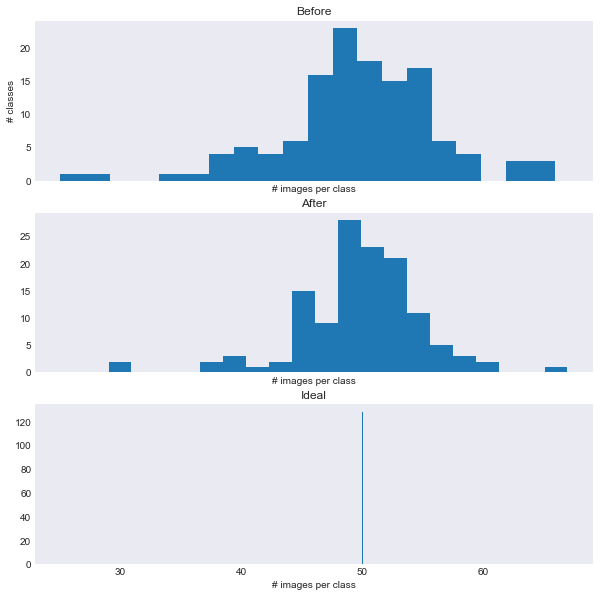

In [25]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax0.hist(pd.Series(val_predicted).value_counts(), bins=20)
ax0.set_xlabel('# images per class')
ax0.set_ylabel("# classes")
ax0.set_title('Before')

ax1.hist(pd.Series(calibrated_val_predicted).value_counts(), bins=20)
ax1.set_xlabel('# images per class')
ax0.set_ylabel("# classes")
ax1.set_title('After')

ax2.hist(pd.Series(list(range(128))*50).value_counts())
ax2.set_xlabel('# images per class')
ax0.set_ylabel("# classes")
ax2.set_title('Ideal')
f;
plt.show()

In [26]:
val_true = np.loadtxt('C:/Users/Dridgers/Desktop/work/datasets/t271221/furniture_val_true.csv', delimiter=',')
print('Score for raw probability:', (val_true != val_predicted).mean())
print('Score for calibrated probability:', (val_true != calibrated_val_predicted).mean())

Score for raw probability: 0.119823649819
Score for calibrated probability: 0.115572350811
